# Minimal with Claude

In [ ]:


# Mars Crater Classification CNN - Impact vs Volcanic
# For use in Google Colab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [ ]:

# Set paths
BASE_PATH = '/content/drive/MyDrive/Dissertation/FinalDataset'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VAL_PATH = os.path.join(BASE_PATH, 'val')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Verify paths exist
for path in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
    if not os.path.exists(path):
        print(f"Warning: Path does not exist: {path}")
    else:
        print(f"Found: {path}")
        # List subdirectories
        subdirs = os.listdir(path)
        print(f"  Subdirectories: {subdirs}")


Found: /content/drive/MyDrive/Dissertation/FinalDataset/train
  Subdirectories: ['Impact', 'Volcanic']
Found: /content/drive/MyDrive/Dissertation/FinalDataset/val
  Subdirectories: ['Impact', 'Volcanic']
Found: /content/drive/MyDrive/Dissertation/FinalDataset/test
  Subdirectories: ['Impact', 'Volcanic']


In [ ]:

# Configuration
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

# Data augmentation and preprocessing
# Minimal augmentation to preserve crater geometry while adding some variation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Small rotation to maintain crater shape integrity
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,  # Craters can be viewed from any orientation
    fill_mode='constant',
    cval=0.0
)

# No augmentation for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=42
)

print("Loading validation data...")
val_generator = val_test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=42
)

print("Loading test data...")
test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=42
)

# Display class mappings
print(f"Class indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

def create_crater_cnn():
    """
    Create CNN architecture optimized for distinguishing crater shapes:
    - Impact craters: circular, raised rims, bowl-shaped
    - Volcanic depressions: elliptical, collapsed, irregular edges
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

        # First block - detect basic edges and textures
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second block - detect curved features and rim patterns
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third block - detect circular vs elliptical patterns
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth block - complex shape analysis
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Global average pooling to reduce overfitting
        layers.GlobalAveragePooling2D(),

        # Dense layers for final classification
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model

# Create and compile model
print("Creating CNN model...")
model = create_crater_cnn()

# Compile with binary crossentropy and Adam optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()


Loading training data...
Found 2400 images belonging to 2 classes.
Loading validation data...
Found 300 images belonging to 2 classes.
Loading test data...
Found 300 images belonging to 2 classes.
Class indices: {'Impact': 0, 'Volcanic': 1}
Training samples: 2400
Validation samples: 300
Test samples: 300
Creating CNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,434,849 (5.47 MB)

 Trainable params: 1,434,849 (5.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Callbacks for training optimization
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '/content/drive/MyDrive/best_crater_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model
print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5220 - loss: 0.6948
Epoch 1: val_accuracy improved from -inf to 0.52083, saving model to /content/drive/MyDrive/best_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 470s 6s/step - accuracy: 0.5219 - loss: 0.6948 - val_accuracy: 0.5208 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4879 - loss: 0.6942
Epoch 2: val_accuracy did not improve from 0.52083
75/75 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.4878 - loss: 0.6942 - val_accuracy: 0.4792 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4955 - loss: 0.6931
Epoch 3: val_accuracy did not improve from 0.52083
75/75 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.4955 - loss: 0.6931 - val_accuracy: 0.5208 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4845 - loss: 0.6939
Epoch 4: val_accuracy did not improve from 0.52083
75/75 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.4845 - loss: 0.6939 - val_accuracy: 0.4792 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 

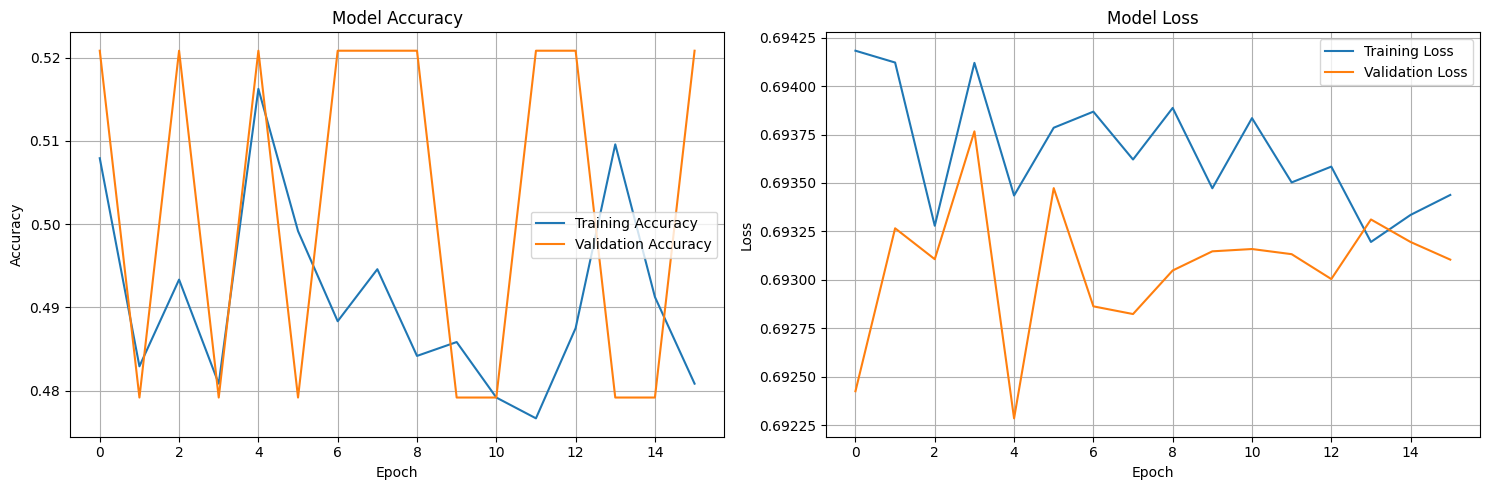


VALIDATION EVALUATION
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7723 - loss: 0.6801
Validation Accuracy: 0.5000
Validation Loss: 0.6934

TEST EVALUATION
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.7723 - loss: 0.6801
Test Accuracy: 0.5000
Test Loss: 0.6934

Generating detailed predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Impact       0.50      1.00      0.67       150
    Volcanic       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


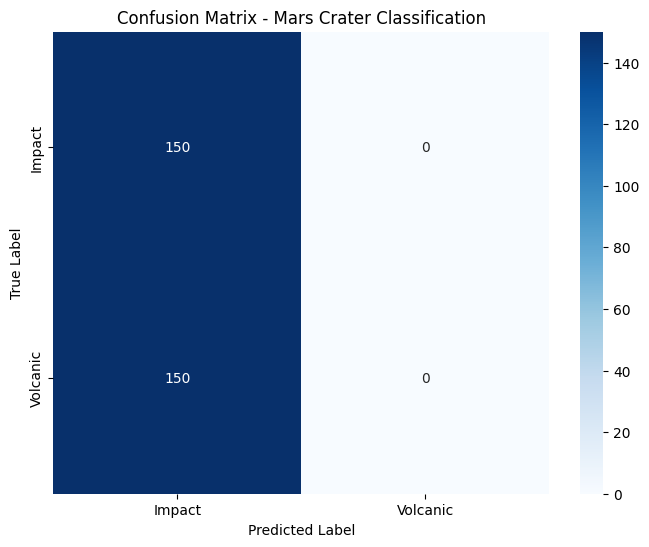


Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


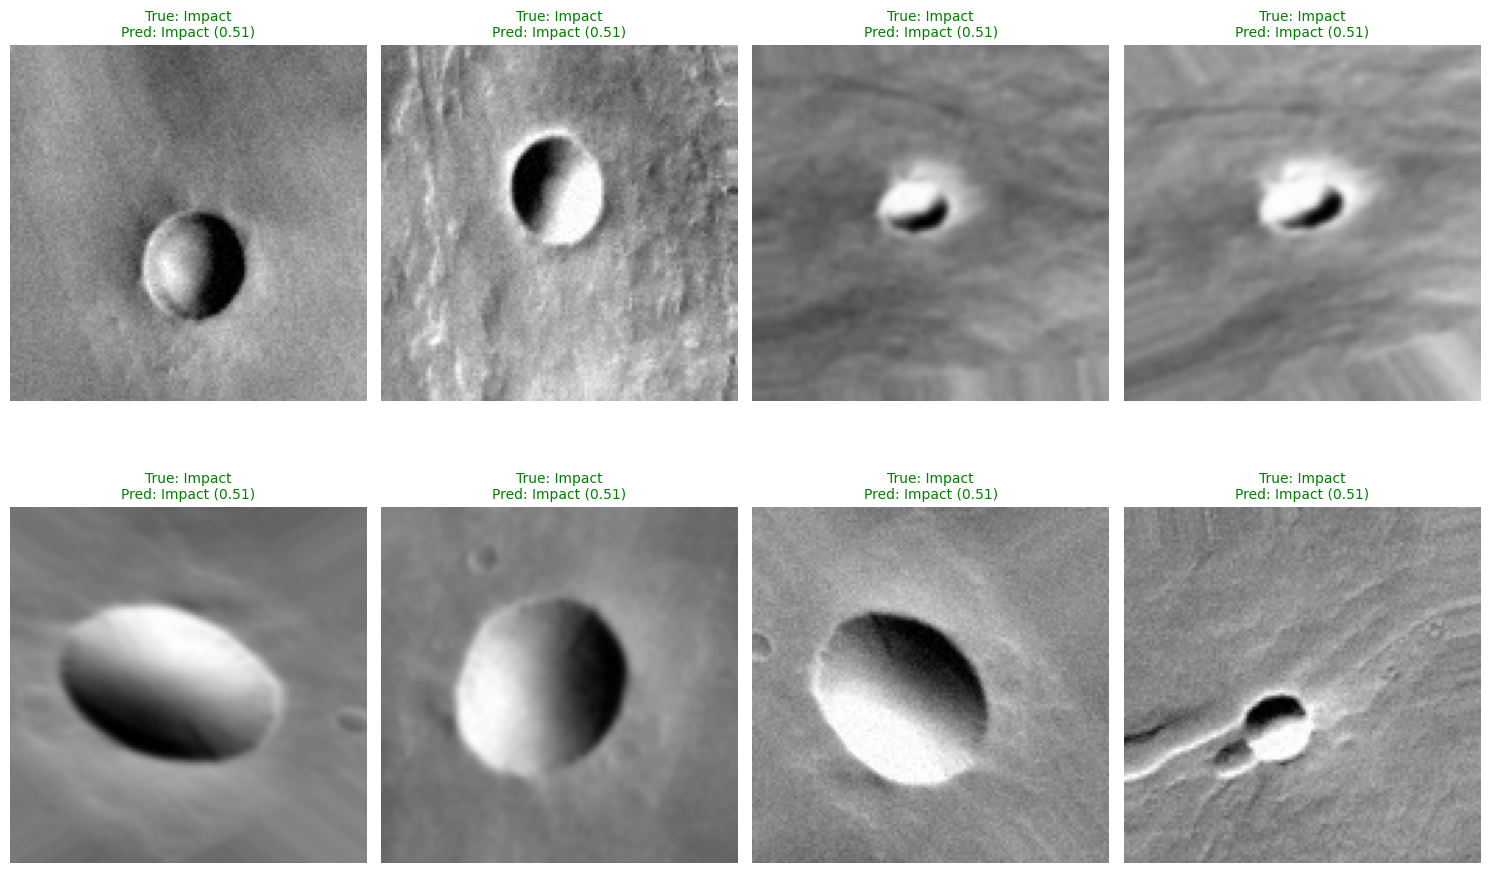


Model saved to Google Drive as 'final_crater_classification_model.h5'

FINAL RESULTS SUMMARY
Final Validation Accuracy: 0.5000 (50.00%)
Final Test Accuracy: 0.5000 (50.00%)
Total Training Epochs: 16


In [ ]:

# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate on validation set
print("\n" + "="*50)
print("VALIDATION EVALUATION")
print("="*50)
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate on test set
print("\n" + "="*50)
print("TEST EVALUATION")
print("="*50)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for detailed analysis
print("\nGenerating detailed predictions...")
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get true labels
true_labels = test_generator.classes

# Classification report
class_names = ['Impact', 'Volcanic']  # Assuming 0=Impact, 1=Volcanic based on alphabetical order
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(true_labels, predicted_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Mars Crater Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display sample predictions
def display_sample_predictions(generator, model, num_samples=8):
    """Display sample images with predictions"""
    generator.reset()
    batch = next(generator)
    images, labels = batch[0], batch[1]
    predictions = model.predict(images)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')

        true_class = 'Impact' if labels[i] == 0 else 'Volcanic'
        pred_prob = predictions[i][0]
        pred_class = 'Impact' if pred_prob < 0.5 else 'Volcanic'
        confidence = (1 - pred_prob) if pred_prob < 0.5 else pred_prob

        color = 'green' if true_class == pred_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class} ({confidence:.2f})',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nSample Predictions:")
display_sample_predictions(test_generator, model)

# Save final model
model.save('/content/drive/MyDrive/final_crater_classification_model.h5')
print("\nModel saved to Google Drive as 'final_crater_classification_model.h5'")

# Summary of results
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Final Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Total Training Epochs: {len(history.history['accuracy'])}")
print("="*60)

# Save

In [ ]:
# Create folder if it doesn't exist
import os
save_dir = "/content/drive/MyDrive/Dissertation/Models"
os.makedirs(save_dir, exist_ok=True)

# Save model
model.save(os.path.join(save_dir, "EXP_005.h5"))
print(f"Model saved to {os.path.join(save_dir, 'EXP_005.h5')}")

import pickle

# Save history object
with open(os.path.join(save_dir, "EXP_005_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

print(f"History saved to {os.path.join(save_dir, 'EXP_005_history.pkl')}")


Model saved to /content/drive/MyDrive/Dissertation/Models/EXP_005.h5
History saved to /content/drive/MyDrive/Dissertation/Models/EXP_005_history.pkl
